Object detection using Transfer Learning of CNN architectures
a. Load in a pre-trained CNN model trained on a large dataset
b. Freeze parameters (weights) in model’s lower convolutional layers
c. Add custom classifier with several layers of trainable parameters to model
d. Train classifier layers on training data available for task
e. Fine-tune hyper parameters and unfreeze more layers as needed


Transfer Learning:
Transfer learning in object detection is a technique where a pre-trained deep learning model, typically a convolutional neural network (CNN), is used as a starting point for training a new object detection model. Instead of training a deep neural network from scratch, transfer learning leverages the knowledge and features learned by the pre-trained model on a large dataset.

Here's how transfer learning works in object detection:

Pre-trained Model: A pre-trained CNN model, such as VGG, ResNet, or MobileNet, that has been trained on a large dataset, often for image classification, is selected as the starting point.

Feature Extraction: The pre-trained model's layers, especially the earlier convolutional layers, are retained. These layers have learned to extract meaningful features from images. They act as feature extractors for the object detection task.

Adaptation: A new set of layers, including object detection-specific layers like anchor boxes, region proposal networks (RPNs), and classification/regression heads, are added on top of the retained layers. These layers are specific to the object detection task and are trained from scratch.

Fine-Tuning: The entire model is trained on a smaller dataset for the specific object detection task. This fine-tuning allows the model to adapt to the new object classes and detection challenges.

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Make predictions using ready made model (without any training)

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

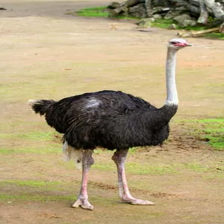

In [4]:
ostrich = Image.open("/content/ostrich.webp").resize(IMAGE_SHAPE)
ostrich

In [5]:
ostrich = np.array(ostrich)/255.0
ostrich.shape

(224, 224, 3)

In [6]:
# used to change the array's shape or dimensions by adding a new axis.

ostrich[np.newaxis, ...]

array([[[[0.77647059, 0.71764706, 0.63137255],
         [0.77647059, 0.71764706, 0.63137255],
         [0.77647059, 0.71764706, 0.63137255],
         ...,
         [0.28235294, 0.29411765, 0.21568627],
         [0.4627451 , 0.47843137, 0.4       ],
         [0.64313725, 0.6627451 , 0.58431373]],

        [[0.77647059, 0.71764706, 0.63137255],
         [0.77647059, 0.71764706, 0.63137255],
         [0.77647059, 0.71764706, 0.63137255],
         ...,
         [0.30980392, 0.32156863, 0.24705882],
         [0.38431373, 0.4       , 0.3254902 ],
         [0.54509804, 0.56470588, 0.49019608]],

        [[0.74509804, 0.68627451, 0.60784314],
         [0.74509804, 0.68627451, 0.60784314],
         [0.74509804, 0.68627451, 0.60784314],
         ...,
         [0.12941176, 0.13333333, 0.07058824],
         [0.17647059, 0.18039216, 0.11764706],
         [0.25882353, 0.26666667, 0.20392157]],

        ...,

        [[0.73333333, 0.63921569, 0.50196078],
         [0.72156863, 0.62745098, 0.49019608]

In [7]:
result = classifier.predict(ostrich[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1001)

In [8]:
#is used to find the index of the maximum value in a NumPy array called result.

predicted_label_index = np.argmax(result)
predicted_label_index

10

In [10]:
# reads a file named "ImageNetLabels.txt" that contains a list of image labels, where each label is on a separate line. It then stores these labels in a Python list called image_labels


image_labels = []
with open("/content/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:11]

['background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

In [11]:
image_labels[predicted_label_index]

'ostrich'

Load flowers dataset

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 [==============================] - 2s 0us/step


In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

Read flowers images from disk into numpy array using opencv

In [14]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [15]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In simple terms, this code uses the OpenCV library (cv2) to read an image file. The image file is specified as the first image in the 'roses' category from a dictionary called flowers_images_dict. The image is loaded and stored in the variable img. This code essentially loads an image of a rose from a collection of flower images for further processing or analysis.

In [16]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [17]:
X = np.array(X)
y = np.array(y)

Train test split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Preprocessing the data


In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Make prediction using pre-trained model on new flowers dataset

In [20]:
X[1].shape

(224, 224, 3)

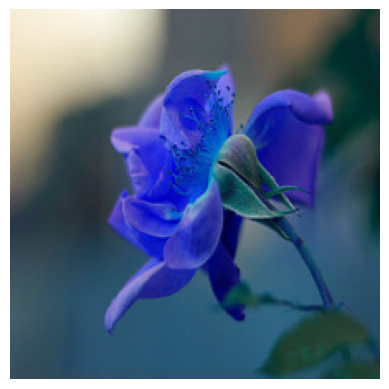

In [21]:
plt.axis('off')
plt.imshow(X[0])

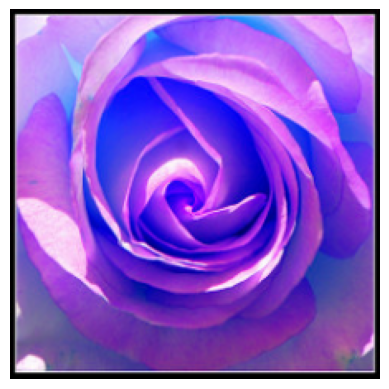

In [22]:
plt.axis('off')
plt.imshow(X[1])

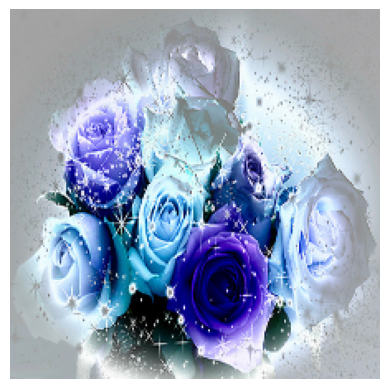

In [23]:
plt.axis('off')
plt.imshow(X[2])

In [ ]:
X[0].shape,X[1].shape,X[2].shape

((224, 224, 3), (224, 224, 3), (224, 224, 3))

In [24]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [25]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 1s/step


array([722, 722, 550])

In [26]:
image_labels[722]

'pillow'

In [27]:
image_labels[550]

'envelope'

Now take pre-trained model and retrain it using flowers images

In [28]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [32]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


model.trainable = True: This line sets the trainable attribute of the model to True. In deep learning, this attribute is typically used to control whether the model's weights should be updated during training. Setting it to True means that the model's weights will be updated during training.

In [34]:
# model.trainable=True .................use this line if it is necessary bcz it takes more time for training(min.30 min)
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=2)#if you set trainible =True then set epoch=2 bcz.it takes time to training otherwise set epoch=2

Epoch 1/5
86/86 [==============================] - 695s 8s/step - loss: 0.6964 - acc: 0.7856
Epoch 2/5
86/86 [==============================] - 646s 7s/step - loss: 0.4355 - acc: 0.8870
Epoch 3/5
59/86 [===================>..........] - ETA: 3:17 - loss: 0.3521 - acc: 0.9057

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 41s 1s/step - loss: 0.3529 - acc: 0.8845


[0.3529245853424072, 0.8845316171646118]